# Machine Learning - Project 2

>Dimitrios Stefanou

>A.M. 3160245

### Package imports and data loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import imageio
from scipy.stats import multivariate_normal

### Image IO

In [2]:
# input fllename >> output 3d array
def read_img(filename):
    img_3d = imageio.imread(filename)
    return img_3d

# input 3d array >> output 2d array
def flatten_img(img_3d):
    x, y, z = img_3d.shape
    img_2d = img_3d.reshape(x*y, z)
    img_2d = np.array(img_2d, dtype = np.float)
    return img_2d

# input 1d prediction array, clusters >> output 2d array
def construct_img(pred, means):
    new_img_2d = np.empty(img_2d.shape)
    for i in range(0, pred.size):
        new_img_2d[i] = means[pred[i]]
    
    return new_img_2d

# input 2d array >> output 3d array
def recover_img(img_2d, x, y):
    img_2d = img_2d.astype(np.uint8)
    recover_img = img_2d.reshape(x, y, 3)
    return recover_img

# image input to 2d array
img_3d = read_img('im.jpg')
print(img_3d.shape)
print('----')
img_2d = flatten_img(img_3d)
print(img_2d.shape)

(690, 550, 3)
----
(379500, 3)


### Probability (γ) and argmax functions

In [3]:
# bayesian probability function
# returns the prob for each to pixel to belong to a cluster
def predict_probs(X, img_size, k, p_k, means, sigma):
    # p(x|k)
    likelihood = np.zeros((img_size, k))
    for i in range(k):
        distribution = multivariate_normal(mean=means[i], cov=sigma[i], allow_singular=True)
        likelihood[:,i] = distribution.pdf(X)

    # p(x|k) * p(k) | numerator of γ(znk)
    pkN = likelihood * p_k 
    # p(x) | | denomimetor of γ(znk)
    SpkN = pkN.sum(axis=1)[:, np.newaxis]
    # bayes | γ(znk)
    gamma = pkN / SpkN
    return gamma

# argmax version of predict_probs
# used to create the predicted image
def predict(X, k, p_k, means, sigma):
    gamma = predict_probs(X, X.shape[0], k, p_k, means, sigma)
    return np.argmax(gamma, axis=1)

# Attempted spherical distribution, unfinished, not working
def norm_pdf_spherical(X, means, sigma):
    likelihood = np.zeros((X.shape[0], k))
    for i in range(k):
        for j in range(X.shape[0]):
            norm_const = 1./ (np.power((2*np.pi) * np.power(sigma[i], 2), X.shape[1]/2))
            norm = np.exp(-0.5 * 1./np.power(sigma[i], 2)) * np.power(np.linalg.norm(X[j] - means[i]), 2)
        # likelihood[?,i] = norm_const * norm
        
    return likelihood

### Gaussian Mixture Model

In [16]:
def plot_costs(costs):
    x = range(1, len(costs)+1)
    y = costs
    plt.plot(x, y)
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title("Cost Function =")
    plt.xticks(np.arange(min(x), max(x)+1, 10))
    plt.show()
    
def gmm(X, k, max_iter, tol):
    
    # Initialize parameters
    img_size = X.shape[0]
    p_k = np.full(shape=k, fill_value=1/k)
    gamma = np.full(shape=X.shape, fill_value=1/k)
    means = np.asarray(random.sample(list(X), k))
    sigma = np.array([np.cov(X.T)*np.identity(X.shape[1]) for z in range(k)])
    Jold = np.inf
    costs = []
    
    for it in range(max_iter):
        # Expectation Step: update gamma and p(k). means and sigma are constant
        gamma = predict_probs(X, img_size, k, p_k, means, sigma)
        p_k = gamma.mean(axis=0)
        
        # Maximization Step: update means and sigma. p(k) and gamma are constant
        for i in range(k):
            prob = gamma[:, [i]]
            total_prob = prob.sum()
            means[i] = (X * prob).sum(axis=0) / total_prob
            sigma[i] = np.cov(X.T,aweights=(prob / total_prob).flatten(), bias=True)*np.identity(X.shape[1])
        
        # Current prediction
        temp_2d_img = construct_img(predict(X, k, p_k, means, sigma), means)
        # Cost function
        # error = ||x_true - x_r||^2 / N
        J = np.power(np.linalg.norm(X - temp_2d_img), 2) / X.shape[0]
        
        # Print progress
        if (it % 10 == 0):
            print("Iteration #{}, Cost function value: {}".format(it, J))
          
        # Check for convergence          
        if (np.abs(J-Jold) < tol) or J > Jold:
            print("Converged. Iteration #{}, Cost function value: {}".format(it, J))
            break
        
        costs.append(J)     
        Jold = J
            
    plot_costs(costs)  
    return p_k, means, sigma

### Model Training

Iteration #0, Cost function value: 577.7263344584461
Iteration #10, Cost function value: 216.08644614897855
Iteration #20, Cost function value: 154.5349952805845
Iteration #30, Cost function value: 148.2841174142662
Converged. Iteration #32, Cost function value: 147.8860227667261


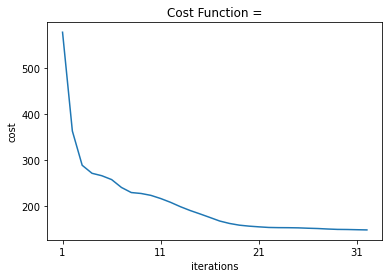

Time:  222


In [24]:
import timeit
start = timeit.default_timer()

k = 64
p_k, means, sigma = gmm(img_2d, k, max_iter=150, tol=1e-4)

stop = timeit.default_timer()
print('Time: ', round(stop - start))  

### Segmented Image Prediction

In [25]:
pred = predict(img_2d, k, p_k, means, sigma)
new_img_2d = construct_img(pred, means)

new_img_3d = recover_img(new_img_2d, img_3d.shape[0], img_3d.shape[1])
imageio.imwrite('img_segm_EM.jpg', new_img_3d)
print("All done.")

All done.
